# Librerias
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2
from tqdm import tqdm
import os
import glob
import tensorflow as tf
import re

# Carga de datos
---

In [18]:
df = pd.read_csv("../../data/train.csv")
df

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


# Ajustes en el dataset
---

Extracción del path y la información contenida en este

In [38]:
def parse_int(s):
    i = j = 0
    while i < len(s):
        while j < len(s) and s[j].isdigit():
            j += 1
        if i < j:
            return int(s[i:j])
        i = j = j + 1
    return math.nan

def extract_image_info(path):
    case_day, fname = path.rsplit("\\", maxsplit=3)[1::2]
    case, day = case_day.split("_")
    slice, height, width = fname.split("_", maxsplit=4)[1:4]
    info = [f"{case}_{day}_slice_{slice}"]
    numeric_info = [case, day, slice, height, width]
    info.extend([parse_int(info) for info in numeric_info])
    return info
    
def create_image_df(path):
    paths = glob.glob(f"{TRAIN_DIR}/**/*.png", recursive=True)
    df = pd.DataFrame({"path": paths})
    info_cols = ["id", "case", "day", "slice", "height", "width"]
    df[info_cols] = df.apply(
        lambda row: extract_image_info(row.path), 
        axis=1,
        result_type="expand"
    )
    return df

TRAIN_DIR = "../../data/train"
data = create_image_df(TRAIN_DIR)
data

,path,id,case,day,slice,height,width
0,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0001,101,20,1,266,266
1,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0002,101,20,2,266,266
2,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0003,101,20,3,266,266
3,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0004,101,20,4,266,266
4,../../data/train\case101\case101_day20\scans\s...,case101_day20_slice_0005,101,20,5,266,266
...,...,...,...,...,...,...,...
38491,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0140,92,0,140,266,266
38492,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0141,92,0,141,266,266
38493,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0142,92,0,142,266,266
38494,../../data/train\case92\case92_day0\scans\slic...,case92_day0_slice_0143,92,0,143,266,266


Modificación del dataset para tener ids unicos manejando las mascaras como columnas

In [39]:
def create_mask_df(df):
    df = df.set_index(["id", "class"]).unstack().reset_index()
    df.columns = "id", 'large_bowel', 'small_bowel', 'stomach'
    df.fillna("", inplace=True)
    df["mask"] = ""
    df["segmented"] = 0
    return df

segmentation = create_mask_df(df)
data = segmentation.merge(data, on="id", how="left")
data

,id,large_bowel,small_bowel,stomach,mask,segmented,path,case,day,slice,height,width
0,case101_day20_slice_0001,,,,,0,../../data/train\case101\case101_day20\scans\s...,101,20,1,266,266
1,case101_day20_slice_0002,,,,,0,../../data/train\case101\case101_day20\scans\s...,101,20,2,266,266
2,case101_day20_slice_0003,,,,,0,../../data/train\case101\case101_day20\scans\s...,101,20,3,266,266
3,case101_day20_slice_0004,,,,,0,../../data/train\case101\case101_day20\scans\s...,101,20,4,266,266
4,case101_day20_slice_0005,,,,,0,../../data/train\case101\case101_day20\scans\s...,101,20,5,266,266
...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case9_day22_slice_0140,,,,,0,../../data/train\case9\case9_day22\scans\slice...,9,22,140,360,310
38492,case9_day22_slice_0141,,,,,0,../../data/train\case9\case9_day22\scans\slice...,9,22,141,360,310
38493,case9_day22_slice_0142,,,,,0,../../data/train\case9\case9_day22\scans\slice...,9,22,142,360,310
38494,case9_day22_slice_0143,,,,,0,../../data/train\case9\case9_day22\scans\slice...,9,22,143,360,310


# Preprocesamiento
---

## Mascaras

Generación y guardado de las máscaras

In [40]:
def generate_mask(seg, shape):
    if seg == "":
        mask = np.zeros(np.prod(shape), dtype=np.uint8)
        mask = np.reshape(mask, shape)
        return mask
    start_list = seg[0::2]
    length_list = seg[1::2]
    mask = np.zeros(np.prod(shape), dtype=np.uint8)
    for start, length in zip(start_list, length_list):
        start = int(start)
        length = int(length)
        mask[start:start + length] = 255
    mask = np.reshape(mask, shape)
    mask = np.ma.masked_where(mask == 0, mask)
    return mask

def save_mask(data):
    for i in tqdm(range(data.shape[0])):
        temp_path = data.iloc[i, 6]
        shape = (data["width"].iloc[i], data["height"].iloc[i])
        
        #LB_dir = temp_path.replace("train", "large_bowel")
        #SB_dir = temp_path.replace("train", "small_bowel")
        #S_dir = temp_path.replace("train", "stomach")
        seg_dir = temp_path.replace("train", "masks")
        
        seg1 = data.iloc[i, 1].split()
        seg2 = data.iloc[i, 2].split()
        seg3 = data.iloc[i, 3].split()
        
        if seg1!=[] or seg2!=[] or seg3!=[]:
            data.iloc[i, 5] = 1
        
        mask1 = generate_mask(seg1, shape)
        mask1 = cv2.resize(mask1, (256, 256))
        mask2 = generate_mask(seg2, shape)
        mask2 = cv2.resize(mask2, (256, 256))
        mask3 = generate_mask(seg3, shape)
        mask3 = cv2.resize(mask3, (256, 256))
        
        #r=large_bowel
        #g=small_bowel
        #b=stomach
        mask = np.dstack((mask1, mask2, mask3))
        
        #os.makedirs(os.path.dirname(LB_dir), exist_ok=True)
        #os.makedirs(os.path.dirname(SB_dir), exist_ok=True)
        #os.makedirs(os.path.dirname(S_dir), exist_ok=True)
        os.makedirs(os.path.dirname(seg_dir), exist_ok=True)
        #cv2.imwrite(LB_dir, mask1)
        #cv2.imwrite(SB_dir, mask2)
        #cv2.imwrite(S_dir, mask3)
        cv2.imwrite(seg_dir, mask)
    
        #data.iloc[i, 1] = LB_dir
        #data.iloc[i, 2] = SB_dir
        #data.iloc[i, 3] = S_dir
        data.iloc[i, 4] = seg_dir
        
    return data
data = save_mask(data)
data

100%|██████████| 38496/38496 [03:20<00:00, 191.74it/s]


,id,large_bowel,small_bowel,stomach,mask,segmented,path,case,day,slice,height,width
0,case101_day20_slice_0001,,,,../../data/masks\case101\case101_day20\scans\s...,0,../../data/train\case101\case101_day20\scans\s...,101,20,1,266,266
1,case101_day20_slice_0002,,,,../../data/masks\case101\case101_day20\scans\s...,0,../../data/train\case101\case101_day20\scans\s...,101,20,2,266,266
2,case101_day20_slice_0003,,,,../../data/masks\case101\case101_day20\scans\s...,0,../../data/train\case101\case101_day20\scans\s...,101,20,3,266,266
3,case101_day20_slice_0004,,,,../../data/masks\case101\case101_day20\scans\s...,0,../../data/train\case101\case101_day20\scans\s...,101,20,4,266,266
4,case101_day20_slice_0005,,,,../../data/masks\case101\case101_day20\scans\s...,0,../../data/train\case101\case101_day20\scans\s...,101,20,5,266,266
...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case9_day22_slice_0140,,,,../../data/masks\case9\case9_day22\scans\slice...,0,../../data/train\case9\case9_day22\scans\slice...,9,22,140,360,310
38492,case9_day22_slice_0141,,,,../../data/masks\case9\case9_day22\scans\slice...,0,../../data/train\case9\case9_day22\scans\slice...,9,22,141,360,310
38493,case9_day22_slice_0142,,,,../../data/masks\case9\case9_day22\scans\slice...,0,../../data/train\case9\case9_day22\scans\slice...,9,22,142,360,310
38494,case9_day22_slice_0143,,,,../../data/masks\case9\case9_day22\scans\slice...,0,../../data/train\case9\case9_day22\scans\slice...,9,22,143,360,310


## Imágenes base

Dado que las imágenes presentan condiciones muy distintas entre ellas, es dificil estableser una metodología para extraer caracteristicas comunes de todas las imágenes, por lo que se realiza una normalización y reescalado a 256px x 256px.

In [533]:
def preprocessing():
    for img in tqdm(data["path"]):
        new_path = re.sub("train", "preprocess", img)
        image = tf.io.read_file(img)
        image = tf.image.decode_image(image, channels=1, dtype=np.float32, expand_animations=False)
        image = tf.image.resize(image, [256,256])
        image = cv2.normalize(image.numpy(), None, 0, 255, norm_type=cv2.NORM_MINMAX)
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        cv2.imwrite(new_path, image)

preprocessing()

100%|██████████| 38496/38496 [03:59<00:00, 160.56it/s]


# Nuevo dataset
---

Creación del nuevo dataset:

In [534]:
data["path"] = data["path"].apply(lambda x: re.sub("train", "preprocess", x))
data

,id,large_bowel,small_bowel,stomach,path,case,day,slice,height,width
0,case101_day20_slice_0001,../../data/large_bowel\case101\case101_day20\s...,../../data/small_bowel\case101\case101_day20\s...,../../data/stomach\case101\case101_day20\scans...,../../data/preprocess\case101\case101_day20\sc...,101,20,1,266,266
1,case101_day20_slice_0002,../../data/large_bowel\case101\case101_day20\s...,../../data/small_bowel\case101\case101_day20\s...,../../data/stomach\case101\case101_day20\scans...,../../data/preprocess\case101\case101_day20\sc...,101,20,2,266,266
2,case101_day20_slice_0003,../../data/large_bowel\case101\case101_day20\s...,../../data/small_bowel\case101\case101_day20\s...,../../data/stomach\case101\case101_day20\scans...,../../data/preprocess\case101\case101_day20\sc...,101,20,3,266,266
3,case101_day20_slice_0004,../../data/large_bowel\case101\case101_day20\s...,../../data/small_bowel\case101\case101_day20\s...,../../data/stomach\case101\case101_day20\scans...,../../data/preprocess\case101\case101_day20\sc...,101,20,4,266,266
4,case101_day20_slice_0005,../../data/large_bowel\case101\case101_day20\s...,../../data/small_bowel\case101\case101_day20\s...,../../data/stomach\case101\case101_day20\scans...,../../data/preprocess\case101\case101_day20\sc...,101,20,5,266,266
...,...,...,...,...,...,...,...,...,...,...
38491,case9_day22_slice_0140,../../data/large_bowel\case9\case9_day22\scans...,../../data/small_bowel\case9\case9_day22\scans...,../../data/stomach\case9\case9_day22\scans\sli...,../../data/preprocess\case9\case9_day22\scans\...,9,22,140,360,310
38492,case9_day22_slice_0141,../../data/large_bowel\case9\case9_day22\scans...,../../data/small_bowel\case9\case9_day22\scans...,../../data/stomach\case9\case9_day22\scans\sli...,../../data/preprocess\case9\case9_day22\scans\...,9,22,141,360,310
38493,case9_day22_slice_0142,../../data/large_bowel\case9\case9_day22\scans...,../../data/small_bowel\case9\case9_day22\scans...,../../data/stomach\case9\case9_day22\scans\sli...,../../data/preprocess\case9\case9_day22\scans\...,9,22,142,360,310
38494,case9_day22_slice_0143,../../data/large_bowel\case9\case9_day22\scans...,../../data/small_bowel\case9\case9_day22\scans...,../../data/stomach\case9\case9_day22\scans\sli...,../../data/preprocess\case9\case9_day22\scans\...,9,22,143,360,310


Exportar el csv con los paths de las imágenes en formato csv:

In [41]:
data[['path', 'mask', 'segmented']].to_csv("../../data/ds_train.csv",index=False)

Los paths de las imágenes serán utilizados para cargar los datos en el modelado en un dataset de tensorflow.

# Ejemplos:

## Antes del preprocesamiento
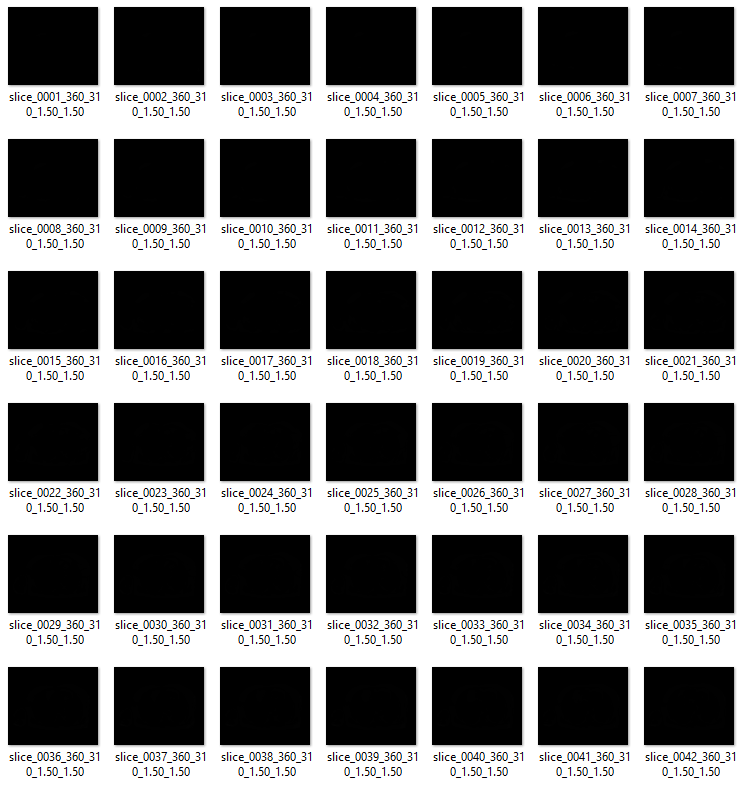
## Despues del preprocesamiento
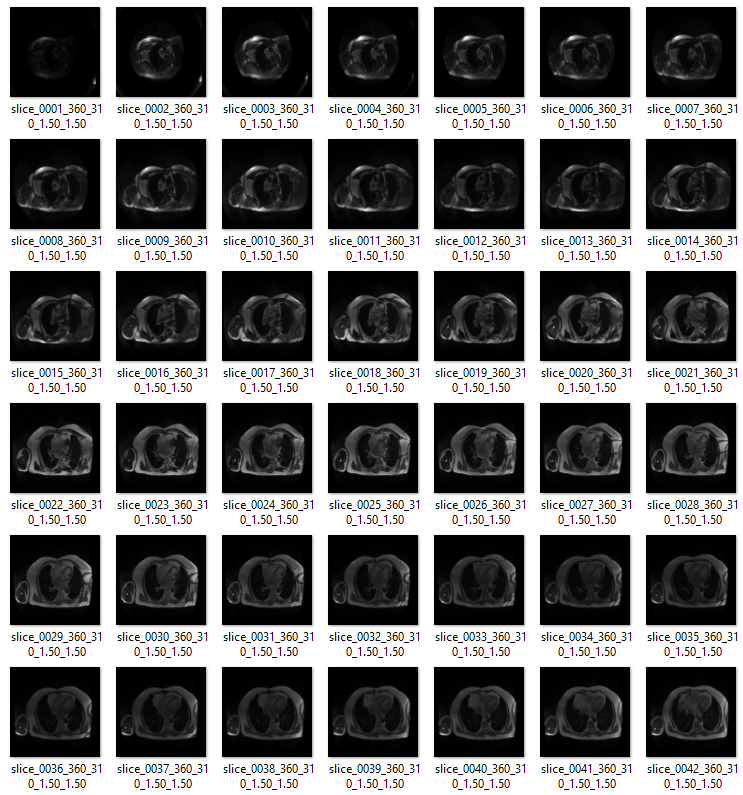

# Mascaras:
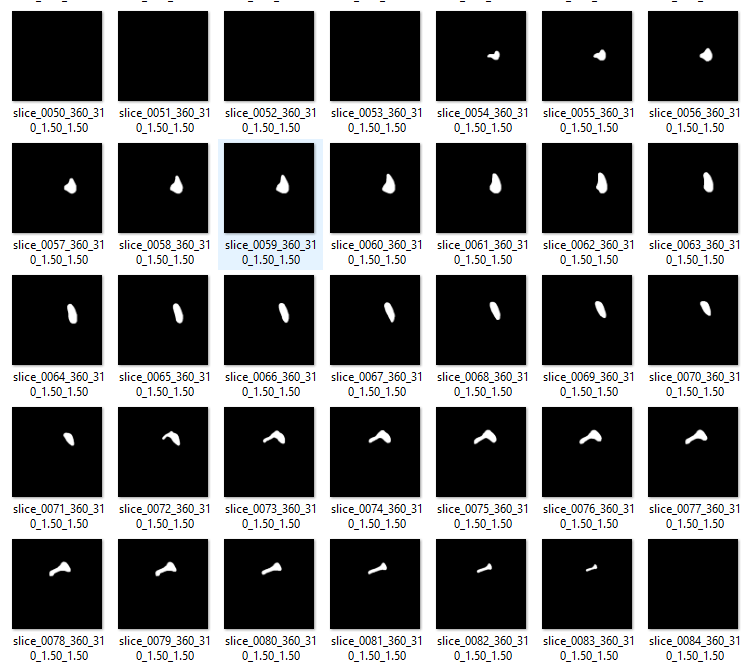